<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/tc_practice/blob/main/06_VAE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jjerry-k/tc_practice/blob/main/06_VAE.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Multilayer Perceptron (MLP)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cpu].


### Dataset

In [11]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define the MLP model

In [4]:
class MultiLayerPerceptronClass(nn.Module):
    """
        Multilayer Perceptron (MLP) Class
    """
    def __init__(self,name='mlp',xdim=784,hdim=256,ydim=10):
        super(MultiLayerPerceptronClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.lin_1 = nn.Linear(self.xdim,self.hdim)
        self.lin_2 = nn.Linear(self.hdim,self.ydim)
        self.init_param() # initialize parameters
        
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self,x):
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net

M = MultiLayerPerceptronClass(name='mlp',xdim=784,hdim=256,ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(),lr=1e-3)
print ("Done.")

Done.


### Simple Forward Path of the MLP Model

In [5]:
x_numpy = np.random.rand(2,784)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = M.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_numpy:\n",x_numpy)
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("y_numpy:\n",y_numpy)

x_numpy:
 [[0.70264569 0.67966673 0.12023421 ... 0.78030288 0.51089884 0.03385399]
 [0.69789137 0.60281841 0.10374722 ... 0.45748859 0.55908277 0.55077233]]
x_torch:
 tensor([[0.7026, 0.6797, 0.1202,  ..., 0.7803, 0.5109, 0.0339],
        [0.6979, 0.6028, 0.1037,  ..., 0.4575, 0.5591, 0.5508]])
y_torch:
 tensor([[ 1.3630,  0.8201, -0.5619,  1.0393,  0.8025,  0.4800,  0.7051, -1.7864,
          0.0074, -0.5274],
        [ 1.0915,  0.5050, -0.5137,  1.3536,  1.5712,  0.4992,  1.0221, -1.3042,
          0.2162, -0.6961]], grad_fn=<AddmmBackward>)
y_numpy:
 [[ 1.3630034   0.82008517 -0.56186044  1.0392537   0.8024575   0.47999397
   0.7050724  -1.7863717   0.0074411  -0.5274311 ]
 [ 1.0915031   0.50500816 -0.51372904  1.3536403   1.5711817   0.4991816
   1.0220823  -1.3041887   0.21621972 -0.6960901 ]]


### Check Parameters

In [6]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(M.named_parameters()):
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
    print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[lin_1.weight] shape:[(256, 784)].
    val:[-0.085 -0.073 -0.041  0.032 -0.025]
[1] name:[lin_1.bias] shape:[(256,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[lin_2.weight] shape:[(10, 256)].
    val:[0.021 0.221 0.01  0.029 0.138]
[3] name:[lin_2.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[203,530].


### Evaluation Function

In [7]:
def func_eval(model,data_iter,device,batch_size=256):
    with torch.no_grad():
        model.eval() # evaluate (affects DropOut and BN)
        n_total,n_correct = 0,0
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,28*28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [8]:
train_accr = func_eval(M,train_iter,device,batch_size=256)
test_accr = func_eval(M,test_iter,device,batch_size=256)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.050] test_accr:[0.048].


### Train

In [9]:
print ("Start training.")
M.init_param() # initialize parameters
M.train()
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(M,train_iter,device,batch_size=256)
        test_accr = func_eval(M,test_iter,device,batch_size=256)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")        

Start training.
epoch:[0] loss:[0.382] train_accr:[0.944] test_accr:[0.942].
epoch:[1] loss:[0.167] train_accr:[0.963] test_accr:[0.960].
epoch:[2] loss:[0.118] train_accr:[0.974] test_accr:[0.967].
epoch:[3] loss:[0.090] train_accr:[0.979] test_accr:[0.972].
epoch:[4] loss:[0.072] train_accr:[0.984] test_accr:[0.974].
epoch:[5] loss:[0.058] train_accr:[0.987] test_accr:[0.976].
epoch:[6] loss:[0.047] train_accr:[0.992] test_accr:[0.979].
epoch:[7] loss:[0.040] train_accr:[0.994] test_accr:[0.980].
epoch:[8] loss:[0.033] train_accr:[0.993] test_accr:[0.978].
epoch:[9] loss:[0.028] train_accr:[0.996] test_accr:[0.980].
Done


### Test

Done


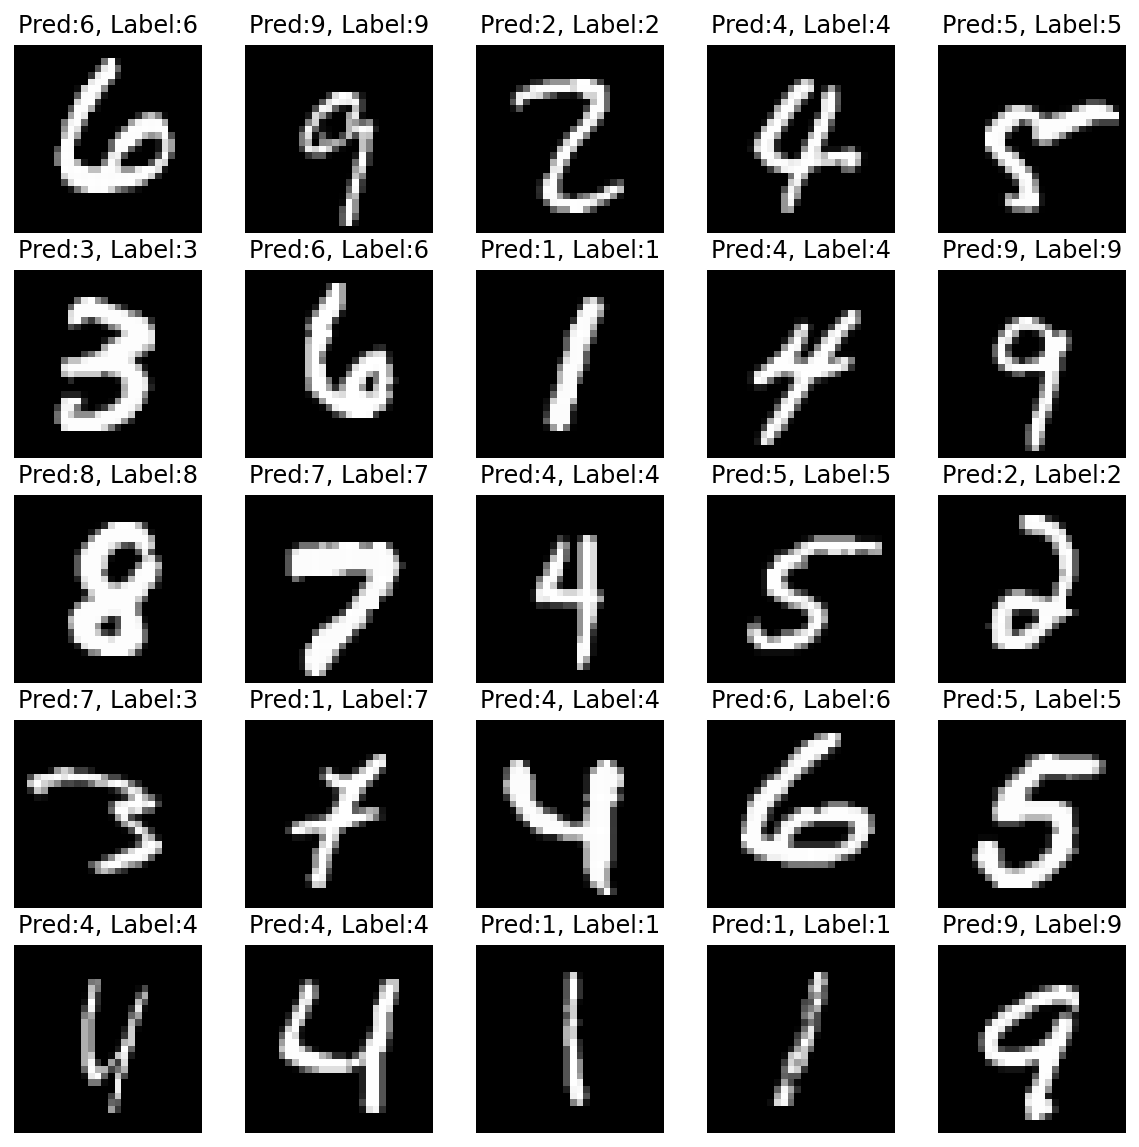

In [10]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device))
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
print ("Done")